### Dataset Loading and testing

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]

#get the ranges of the loaded data
num_layers = X.shape[1]
num_lpoints = Y.shape[1]
size_max = np.amax(X)
size_min = np.amin(X)
size_av = 0.5*(size_max + size_min)

#this information is not given in the dataset
lam_min = 300
lam_max = 1200
lams = np.linspace(lam_min, lam_max, num_lpoints)

#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# normalize inputs 
x_train = (x_train - 50)/20 
x_test = (x_test - 50)/20 

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


Dataset has been loaded
x-train (60000, 8)
x-test  (40000, 8)
y-train (60000, 250)
y-test  (40000, 250)


### Model Development

In [120]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]



#define various models here
#naive percentage loss
def size_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_err = np.abs(y_true - y_pred)/y_true
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)


#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return np.mean(y_err)

def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'])
    return model

import timeit
#here we must have a function that calls the training routine n times and then gives avg and stddev 
# of the resulting figures
def net_performance(modelfunc, num_trials=3, batch_size=32, num_epochs=200, num_gpus=2):
    models = []
    train_err = np.ones(num_trials)
    test_err = np.ones(num_trials)
    val_err = np.ones(num_trials)
    train_time = np.ones(num_trials)
    for tnum in np.arange(num_trials):
        print("iteration: " + str(tnum + 1))
        model_curr = modelfunc()
        x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        start_time = timeit.default_timer()
        history = model_curr.fit(x_t, y_t,
                    batch_size=batch_size*num_gpus,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=(x_v, y_v))
        train_time[tnum] = timeit.default_timer() - start_time
        models.append(model_curr)
        train_err[tnum] =  (100.0/num_lpoints)*history.history['loss'][-1]/(batch_size*num_gpus)
        val_err[tnum] =   (100.0/num_lpoints)*history.history['val_loss'][-1]/(batch_size*num_gpus)
        test_err[tnum] = calc_mre(y_test, models[tnum].predict(x_test))
    return train_err, val_err, test_err, train_time

#staging area for new models 
def plot_training_history(history, factor):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(factor)
    val_loss = np.asarray(val_loss)/(factor)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='validation error')
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Mean Relative Error (MRE) (%)')
    axs.legend(loc="best")


### Model testing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 250)               2250      
_________________________________________________________________
second (Dense)               (None, 250)               62750     
_________________________________________________________________
third (Dense)                (None, 250)               62750     
_________________________________________________________________
fourth (Dense)               (None, 250)               62750     
_________________________________________________________________
last (Dense)                 (None, 250)               62750     
Total params: 253,250
Trainable params: 253,250
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/500
 3072/48000 [>.............................] - ETA: 3s - loss: 3567.9151

/home/hegder/anaconda3/envs/deep/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 3s 55us/step - loss: 758.9194 - val_loss: 282.3995
Epoch 2/500
48000/48000 [==============================] - 3s 54us/step - loss: 234.1059 - val_loss: 226.3511
Epoch 3/500
48000/48000 [==============================] - 3s 55us/step - loss: 197.5172 - val_loss: 170.8384
Epoch 4/500
48000/48000 [==============================] - 3s 55us/step - loss: 177.7809 - val_loss: 166.2469
Epoch 5/500
48000/48000 [==============================] - 3s 56us/step - loss: 174.9649 - val_loss: 158.2008
Epoch 6/500
48000/48000 [==============================] - 3s 57us/step - loss: 158.9374 - val_loss: 135.4285
Epoch 7/500
48000/48000 [==============================] - 3s 56us/step - loss: 143.9555 - val_loss: 145.0782
Epoch 8/500
48000/48000 [==============================] - 3s 55us/step - loss: 141.5145 - val_loss: 125.5494
Epoch 9/500
48000/48000 [==============================] - 3s 54us/step - loss: 131.5325 - val_loss: 114.3913
Epoch 10/500
48000/480

48000/48000 [==============================] - 3s 57us/step - loss: 44.7438 - val_loss: 45.3806
Epoch 77/500
48000/48000 [==============================] - 3s 60us/step - loss: 44.8231 - val_loss: 50.9379
Epoch 78/500
48000/48000 [==============================] - 3s 58us/step - loss: 43.1008 - val_loss: 39.0430
Epoch 79/500
48000/48000 [==============================] - 3s 56us/step - loss: 43.3039 - val_loss: 41.3852
Epoch 80/500
48000/48000 [==============================] - 3s 56us/step - loss: 42.3276 - val_loss: 42.0595
Epoch 81/500
48000/48000 [==============================] - 3s 58us/step - loss: 43.9928 - val_loss: 38.8166
Epoch 82/500
48000/48000 [==============================] - 3s 57us/step - loss: 42.8816 - val_loss: 42.0762
Epoch 83/500
48000/48000 [==============================] - 3s 58us/step - loss: 42.8535 - val_loss: 45.9878
Epoch 84/500
48000/48000 [==============================] - 3s 57us/step - loss: 42.2073 - val_loss: 41.6998
Epoch 85/500
48000/48000 [======

Epoch 151/500
48000/48000 [==============================] - 3s 66us/step - loss: 33.5639 - val_loss: 33.6711
Epoch 152/500
48000/48000 [==============================] - 4s 84us/step - loss: 34.0519 - val_loss: 33.8243
Epoch 153/500
48000/48000 [==============================] - 4s 84us/step - loss: 33.2443 - val_loss: 32.4102
Epoch 154/500
48000/48000 [==============================] - 4s 79us/step - loss: 32.3214 - val_loss: 32.2271
Epoch 155/500
48000/48000 [==============================] - 3s 65us/step - loss: 32.7965 - val_loss: 33.2654
Epoch 156/500
48000/48000 [==============================] - 4s 73us/step - loss: 32.6712 - val_loss: 30.4121
Epoch 157/500
48000/48000 [==============================] - 4s 86us/step - loss: 32.3887 - val_loss: 30.3289
Epoch 158/500
48000/48000 [==============================] - 4s 83us/step - loss: 32.5708 - val_loss: 31.8003
Epoch 159/500
48000/48000 [==============================] - 3s 68us/step - loss: 32.6873 - val_loss: 32.6164
Epoch 160/

48000/48000 [==============================] - 4s 80us/step - loss: 26.4554 - val_loss: 27.6248
Epoch 300/500
48000/48000 [==============================] - 4s 79us/step - loss: 26.3397 - val_loss: 27.3131
Epoch 301/500
48000/48000 [==============================] - 4s 83us/step - loss: 26.8168 - val_loss: 26.3744
Epoch 302/500
48000/48000 [==============================] - 4s 82us/step - loss: 26.5952 - val_loss: 26.8149
Epoch 303/500
48000/48000 [==============================] - 3s 68us/step - loss: 26.6466 - val_loss: 26.5184
Epoch 304/500
48000/48000 [==============================] - 3s 62us/step - loss: 26.6730 - val_loss: 26.1914
Epoch 305/500
48000/48000 [==============================] - 4s 81us/step - loss: 26.1043 - val_loss: 26.3095
Epoch 306/500
48000/48000 [==============================] - 4s 83us/step - loss: 26.4369 - val_loss: 28.0487
Epoch 307/500
48000/48000 [==============================] - 4s 82us/step - loss: 26.2047 - val_loss: 25.1290
Epoch 308/500
48000/4800

48000/48000 [==============================] - 3s 56us/step - loss: 24.1495 - val_loss: 25.5476
Epoch 448/500
48000/48000 [==============================] - 3s 56us/step - loss: 24.3558 - val_loss: 23.3325
Epoch 449/500
48000/48000 [==============================] - 3s 56us/step - loss: 24.3355 - val_loss: 22.3278
Epoch 450/500
48000/48000 [==============================] - 3s 57us/step - loss: 24.0114 - val_loss: 27.5925
Epoch 451/500
48000/48000 [==============================] - 3s 57us/step - loss: 24.3896 - val_loss: 23.1899
Epoch 452/500
48000/48000 [==============================] - 3s 57us/step - loss: 23.8576 - val_loss: 24.7734
Epoch 453/500
48000/48000 [==============================] - 3s 57us/step - loss: 24.1396 - val_loss: 22.7870
Epoch 454/500
48000/48000 [==============================] - 3s 56us/step - loss: 24.0953 - val_loss: 24.4784
Epoch 455/500
48000/48000 [==============================] - 3s 55us/step - loss: 24.0795 - val_loss: 24.2511
Epoch 456/500
48000/4800

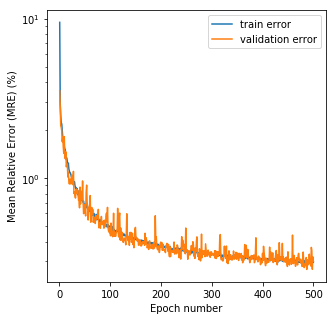

In [116]:


    
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))
 
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
model = naiveploss_mgpu_model()
model.summary()   
history = model.fit(x_t, y_t,
                    batch_size=64,
                    epochs=500, 
                    verbose=1,
                    validation_data=(x_v, y_v))
plot_training_history(history)

y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))


(1, 250)


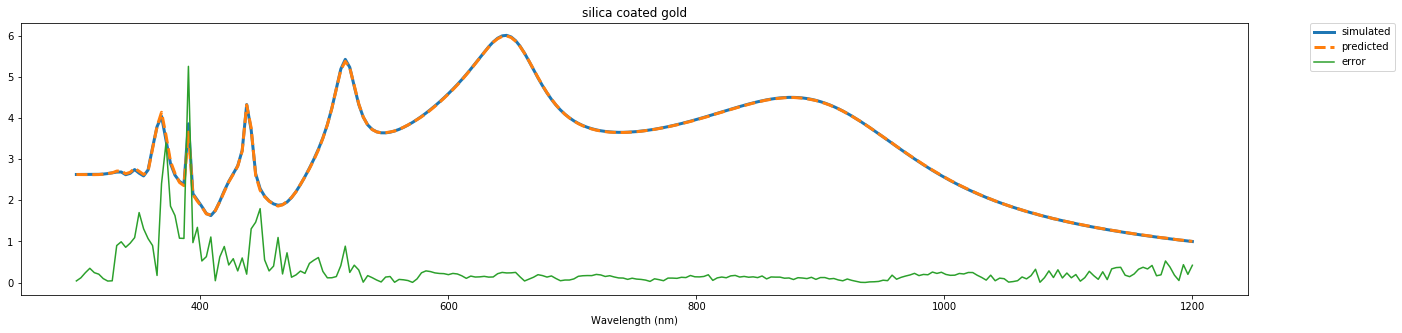

In [58]:
import snlay as snlay
#here we test edge cases where failure happens
#size = np.array([70, 60, 50, 40, 30, 20, 10, 10])
#size = np.array([70, 70, 70, 70, 70, 70, 70, 70])
#size = np.array([30, 30, 30, 30, 30, 30, 30, 30])

size = np.array([35, 65, 35, 65, 35, 65, 35, 65])
#size = np.array([50, 50, 50, 50, 50, 50, 50, 50])
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
spec_ac = snlay.calc_spectrum(size, mats, lams)




size = (size - 50.0)/20.0

spec = model.predict(np.expand_dims(size, axis = 0))
print(spec.shape)
spec = np.ravel(spec)


fig1 = plt.figure(figsize=(22,5))
ax = fig1.add_subplot(1,1,1)
ax.set_title('silica coated gold')
ax.set_xlabel('Wavelength (nm)')
plt.plot(lams, spec_ac, linewidth=3, label='simulated')
plt.plot(lams, spec, '--', linewidth=3, label='predicted')
plt.plot(lams, 100*np.abs(spec_ac - spec)/spec_ac, label='error')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Model Benchmarking

In [ ]:
#Here is where we in-depth model evaluation and benchmarking

#model = naiveploss_model()
train_e, val_e, test_e, train_t = net_performance(naiveploss_model, 5, 64, 500, 1)

print("Training duration")
print(np.mean(train_t), np.std(train_t))

print("Training error")
print(np.mean(train_e), np.std(train_e))

print("Validation error")
print(np.mean(val_e), np.std(val_e))

print("Testing error")
print(train_e)
print(np.mean(train_e), np.std(train_e))





\\7]=/ we record the timing and resource consumption 
'
- naiveploss,  

  Total params: 253,250,  
  training size: 48,000    val size 12,000    test size: 40,000 
  
 1 gpu case, 500 epochs, 64 batch size. 
 Training duration
970.6306939371977 162.52772916709793
Training error
0.28162434966405236 0.004849006439278184
Validation error
0.28847073678970336 0.01748113934849215
Testing error
[0.28093684 0.29020114 0.28278018 0.27629951 0.27790407]
0.28162434966405236 0.004849006439278184
   
 
 2 gpu case, 500 epochs, 64 batch size. 
  Training duration
1415.9011616169942 72.01714343631177
Training error
0.14291583093007407 0.0017661558666610126
Validation error
0.14036797358194988 0.005636169118478038
Testing error
[0.14436209 0.14525352 0.14023539 0.14201304 0.14271513]
0.14291583093007407 0.0017661558666610126
  
  


### Inverse scattering 

[49 60 37 39 37 43 46 35]
[47. 51. 34. 46. 43. 45. 46. 35.]


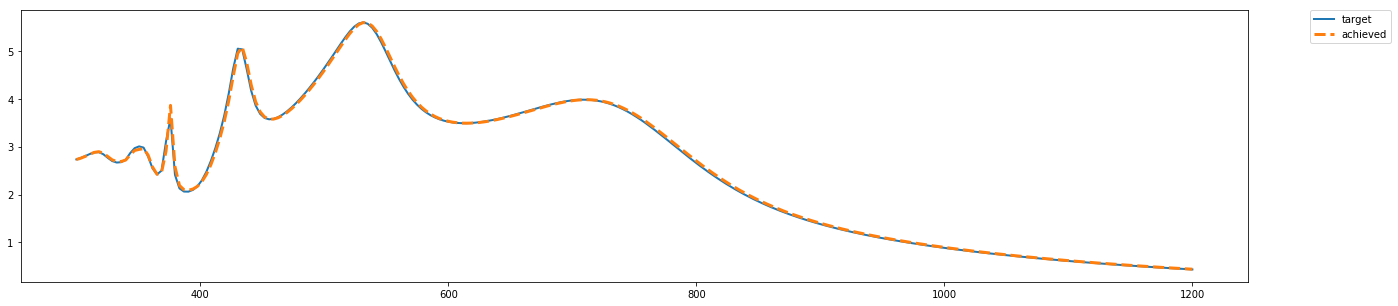

In [92]:


model_d = Sequential()
model_d.add(Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False))

for layer in model.layers:
    model_d.add(layer)

for layer in model_d.layers[1:]:
    layer.trainable = False

for ind in range(1,len(model_d.layers)):
    model_d.layers[ind].set_weights(model.layers[ind-1].get_weights())

model_d.compile(loss=naive_percent_loss, optimizer='adam')    
    
    
#model_d.summary()


# # let us create a target spectrum first
import snlay as snlay
#size = np.array([60, 65, 65, 65, 35, 35, 35, 35])
size = np.random.randint(30,70,8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
target = snlay.calc_spectrum(size, mats, lams)

print(size)

# #do the training here
xd_t = np.ones((1,1))
yd_t = target.reshape(1,250)





history = model_d.fit(xd_t, yd_t,
                    batch_size=1,
                    epochs=5000, 
                    verbose=0)

# #here is the final result
size_out = model_d.get_layer('dummy')
wts = size_out.get_weights()
wts = np.array(wts).ravel()
size_res= 0.5*wts*(size_max - size_min) + size_av
size_res_rounded = np.round(size_res)

spec_zer = model_d.predict(xd_t).ravel()
achieved = snlay.calc_spectrum(size_res_rounded, mats, lams)


fig1 = plt.figure(figsize=(22,5))
ax = fig1.add_subplot(1,1,1)
#plt.plot(lams, spec_zer, label='new model')
plt.plot(lams, target, linewidth=2, label='target')
plt.plot(lams, achieved, '--', linewidth=3, label='achieved')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(size_res_rounded)


### Model shipment

In [ ]:

    
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')

